In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat
#import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
CUR_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
if CUR_PATH not in sys.path:
  sys.path.append(CUR_PATH)

#for load params of trained model
SL_MODEL_NAME = "conv4_bn_mini"
SL_No = 40
SL_PARAM_NAME = f"SLpn_{SL_MODEL_NAME}_{SL_No}"
SL_PARAM_PATH = os.path.join(CUR_PATH, "SLpn_params", f"{SL_PARAM_NAME}.pth")

#for save params of policy model
MODEL_NAME = "dqn_conv4"
No = 61
PARAM_NAME = f"RLpn_{MODEL_NAME}_{No}"
PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{PARAM_NAME}.pth")
BEST_PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{PARAM_NAME}_best.pth")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


RL model:

- 1: vs SL model, select_action=determinism, lr=2e-5

- 2: select_action=probability theory, lr=1e-6?

- 21: vs random action, select_action=determine, lr=5e-6, EPOCH=5000

- 22: select_action=determine

- 23: reward=my stones: (win, draw, lose)=(1.0 to 0.5, 0.0, -0.5 to -1.0), win,lr=8e-6, EPOCH=5000

- 24: select_action_random=probability in capable place, lr=2e-5, EPOCH=200

- 41: SLmodel=trained nodup-nowrong-trained data, EPOCH=1024, episode=2*2, target update=2 lr=4e-06

- 51: reward: (win, draw, lose)=(1., 0., -1.), lr=8e-06

- 61: 1 data got in a battle, EPOCH=1024, episode=2*32, target update=1, PARAM_STOCK=16, EPS_START=0.16=5/32, EPS_END=0.03=1/32

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
import gym
import tools
env = gym.make("othello-v0")

#defining hyper parameters

In [ ]:
#LR = 0.000001
GAMMA = 0.99
buffer_limit = 5000
BATCH_SIZE = 64
POSTMAX = 25
dummy_data = 64

#making replay memory

In [ ]:
#transition = (board, player, reward)

class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.reset()


  def reset(self):
    self.idx = 0
    self.states = []
    self.actions = []
    self.nexts = []
    self.players = []
    self.posts = []
    self.next_posts = []
  

  def push(self, state, action, next_state, player, posts, next_posts):
    if self.idx < self.capacity:
      self.states.append([None])
      self.actions.append(None)
      self.nexts.append([None])
      self.players.append(None)
      self.posts.append(None)
      self.next_posts.append(None)
    self.states[self.idx] = state
    self.actions[self.idx] = action
    self.nexts[self.idx] = next_state
    self.players[self.idx] = player
    self.posts[self.idx] = posts
    self.next_posts[self.idx] = next_posts
    self.idx = (self.idx + 1) % self.capacity


  def __getitem__(self, idx):
    return self.states[idx], self.actions[idx], self.nexts[idx], self.players[idx], self.posts[idx], self.next_posts[idx]


  def sample(self, batch_size):
    idxs = [i for i in range(self.idx)]

    if batch_size >= self.idx:
      return idxs, (self.states, self.actions, self.nexts, self.players, self.posts, self.next_posts)

    else:
      idxs = random.sample(idxs, batch_size)
      return idxs, ([self.states[idx] for idx in idxs], [self.actions[idx] for idx in idxs],[self.nexts[idx] for idx in idxs],
                    [self.players[idx] for idx in idxs], [self.posts[idx] for idx in idxs], [self.next_posts[idx] for idx in idxs])
  

  def __len__(self):
    return self.idx


  def __call__(self, mode = "all"):
    if mode == "all":
      return (self.states, self.actions, self.nexts, self.players, self.posts, self.next_posts)
    elif mode == "reward":
      return self.players
    else:
      return 0

#defining model

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making transform

In [ ]:
#transform for action
def rotate90(x, y, k):
  for _ in range(k):
    x, y = y, -1*x + 7
  return x, y


def flip(x, y):
  x, y = x, -1*y + 7
  return x, y


def transform_posts(posts, k=0):
    n = sum(pt > 63 for pt in posts)
    x, y = [ps % 8 for ps in posts], [ps // 8 for ps in posts]
    p = k % 2
    if p > 0:
        x, y = x, [-1 * py + 7 for py in y] #flip
    for _ in range(k):
        x, y = y, [-1 * px + 7 for px in x] #rotate90
    posts = [x + y * 8 for x, y in zip(x, y)]
    if n > 0:
        posts[POSTMAX - n:] = [dummy_data] * n
    if n > POSTMAX:
        print(f"n: {n} is over POSTMAX: {POSTMAX}!")
    return posts


#making transform
def transform(state, action, k=0, mode = "None"):
  x, y = action%8, action//8
  if mode == "train":
    #k = random.randint(0, 3)
    p = k % 2
    if p > 0:
      state = np.flip(state, axis=1).copy()
      x, y = flip(x, y)
    state = np.rot90(state, k, axes=(1, 2)).copy()
    x, y = rotate90(x, y, k)

  elif mode == "valid":
    pass

  elif mode == "debug":
    k = 3 #0-3 existable pattern
    p = k % 2
    if p > 0:
      state = np.flip(state, axis=1).copy()
      x, y = flip(x, y)
    state = np.rot90(state, k, axes=(1, 2)).copy()
    x, y = rotate90(x, y, k)

  else:
    pass
    
  action = x + y*8
  return state, action

#making dataset

In [ ]:
#board => 3 dim state
#player = 1: white, 2: black
class DQNDatasets(Dataset):
  def __init__(self, state, action, next_state, player, reward, posts, next_posts):
    self.state = state
    self.action = np.array(action)
    self.next_state = next_state
    self.player = player #player = next_player
    self.reward = reward
    self.posts = posts
    self.next_posts = next_posts

  def __len__(self):
    return len(self.player)
  
  def __getitem__(self, idx):
    state = self.state[idx].reshape((-1, 8, 8)).astype("float32")
    next_state = self.next_state[idx].reshape((-1, 8, 8)).astype("float32")
    action = self.action[idx]
    posts = self.posts[idx]
    next_posts = self.next_posts[idx]

    k = random.randint(0, 3) #for transform
    state, action = transform(state, action, k, "train")
    next_state, _ = transform(next_state, 0, k, "train")
    if len(posts) > 0: 
        posts = transform_posts(posts, k)[:]
    if len(next_posts) > 0:
        next_posts = transform_posts(next_posts, k)[:]

    white_st = np.where(state == 3 - self.player[idx], 1, 0)
    black_st = np.where(state == self.player[idx], 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 1).reshape(3, 8, 8) #axis check

    #action = self.action[idx]

    #next_state = self.next_state[idx].reshape((-1, 8, 8)).astype("float32")
    white_nst = np.where(next_state == self.player[idx], 1, 0)
    black_nst = np.where(next_state == 3 - self.player[idx], 1, 0)
    bw_nst = np.where(next_state > 0, 1, 0)
    next_state = np.stack([bw_nst, white_nst, black_nst], axis = 1).reshape(3, 8, 8)

    reward = self.reward[idx]

    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    next_state = torch.tensor(next_state).float()
    reward = torch.tensor(reward).float()
    posts = torch.tensor(posts).long()
    next_posts = torch.tensor(next_posts).long()
    return state, action, next_state, reward, posts, next_posts

#making select action

In [ ]:
EPS_START = 0.16 #=5/32 #max
EPS_END = 0.03 #=1/32 #min
EPS_DECAY = 500#1000 #decay to decrease
NO_RANDOM = 99999 #for not use value of return -1

def select_action(epoch, state, player, policy_model, posts):
  p = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * epoch / EPS_DECAY)
  if epoch == NO_RANDOM:
    p = eps_threshold + 0.1
  if p > eps_threshold:

    state = state.astype("float32")
    white_st = np.where(state == 3 - player, 1, 0)
    black_st = np.where(state == player, 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8) #axis check
    state = torch.tensor(state).float()
    state = state.to(device)

    #state, _, _, _ = DQNDatasets(state, 0, state, player, 0)[0]
    policy_model.eval()
    with torch.no_grad():
      pred = policy_model(state)
      #return pred.max(1)[1].reshape(-1, 1) #determinism
      #pred = nn.Softmax(dim=0)(pred.reshape(64)) #prob
      #return torch.multinomial(pred, 1).reshape(-1, 1) #probability theory
      if len(posts) > 0: #exist to place
        pred = torch.gather(pred, 1, torch.tensor([posts], device=device, dtype=torch.long)) #prob in capable to place=no miss
        pred = nn.Softmax(dim=1)(pred)
        idx = torch.multinomial(pred, 1).item()
        return torch.tensor([posts[idx]], device=device, dtype=torch.long)
      else: #skip turn
          return pred.max(1)[1].reshape(-1, 1)

  else:
      #state = state.reshape(-1, 8*8) #random in all void places
      #state = state[0]
      #state = np.where(state == 1, 0, 1)
      #state = torch.tensor(state).float()
      #state = state.to(device)
      #return torch.multinomial(state, 1).reshape(-1, 1)
      return torch.tensor([-1], device = device, dtype = torch.long) #random in place able only

#making optimize 

In [ ]:
GAMMA = 0.99 #0.99
alpha = 0.1 #to match reward to pred values

def optimize_model(policy_model, target_model, memory, reward, wrong=0):
  tdloss = 0
  
  state, action, next_state, player, posts, next_posts = memory
  dqn_dataset = DQNDatasets(state, action, next_state, player, reward, posts, next_posts)
  dqn_loader = DataLoader(dqn_dataset, batch_size = BATCH_SIZE, shuffle = True)

  for state, action, next_state, reward, posts, next_posts in dqn_loader:
    state = state.to(device)
    action = action.to(device)
    next_state = next_state.to(device)
    reward = reward.to(device)
    posts = posts.to(device)
    next_posts = next_posts.to(device)
    #Q(s_t, a)
    #calculate Q(s_t) get a = actions
    #all actions lead policy_net
    policy_model.train()
    pred = policy_model(state)
    state_action_values = pred.gather(1, action)
    
    #calcurate V(s_{t+1}) about all next states.
    #Expected value at next state on non_final_next_ by target net before update.
    #this values are 0 at final and expected values on next at others.
    next_state_values = torch.zeros(state.shape[0], device=device)
    #next_pred = target_model(next_state).detach()
    #next_pred = torch.cat((next_pred, torch.tensor([[-1000.0] for _ in range(next_pred.shape[0])], device = device)), 1) #posts=64: None
    #next_pred = torch.gather(next_pred, 1, next_posts) #in capable to place
    #next_state_values = next_pred.max(1)[0].detach() #capable

    next_state_values = target_model(next_state).max(1)[0].detach() #in all positions

    #calculate expected Q value
    #more expected_sa_value: next_state = next_my_state = after 2 steps
    expected_state_action_values = GAMMA * next_state_values + reward * alpha
    if wrong:
      expected_state_action_values = reward

    #calculate Huber loss
    #print(state_action_values[0].item(), expected_state_action_values.unsqueeze(1)[0].item())
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    #update model param
    optimizer.zero_grad()
    loss.backward()
    for param in policy_model.parameters():
      param.grad.data.clamp_(-1, 1)
    optimizer.step()
    tdloss += loss.item() / len(dqn_loader)
  return tdloss

#making model

In [ ]:
policy_model = Conv4_bn_mini().to(device)
policy_model.load_state_dict(torch.load(SL_PARAM_PATH, map_location = device))
target_model = Conv4_bn_mini().to(device)
target_model.load_state_dict(policy_model.state_dict())
target_model.eval()
opponent_model = Conv4_bn_mini().to(device)
opponent_model.load_state_dict(policy_model.state_dict())
opponent_model.eval()

Conv4_bn_mini(
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
)

#function of vs random

In [ ]:
W, B = 1, 2
color = ("white", "black")
num_battle = 100
op_model = Conv4_bn_mini().to(device)
op_model.load_state_dict(torch.load(SL_PARAM_PATH, map_location = device))
op_model.eval()


def np_to_feature(state, player):
  state = state.astype("float32")
  white_st = np.where(state == 3 - player, 1, 0)
  black_st = np.where(state == player, 1, 0)
  bw_st = np.where(state > 0, 1, 0)
  state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
  state = torch.tensor(state).float()
  state = state.to(device)
  return state


def op_select_action(state, player, _op_model=None, mode="max"):
  state = np_to_feature(state, player)
  if _op_model == None: #random
    action = torch.tensor([-1], device = device, dtype = torch.long).reshape(-1, 1)
  elif mode == "max":
    _op_model.eval()
    with torch.no_grad():
      action = _op_model(state).max(1)[1].reshape(-1, 1)
  elif mode == "prob":
    _op_model.eval()
    with torch.no_grad():
      pred = _op_model(state)
      pred = nn.Softmax(dim=0)(pred.reshape(64))
      action = torch.multinomial(pred, 1).reshape(-1, 1)
  return action
  

def vs_play(model, model_mode="random", select_mode="max", battles=num_battle):
  winrate = [0, 0] #AI: white, black
  model.eval()
  for play in (W, B):
    wincnt = [0, 0] #white, black
    accuracy = [0, 0] #Right Wrong
    for _ in range(battles):
      env.reset()
      while not env.done:
        player = env.player
        state = env.render("rgb_array")
        if player == play:#play : policy model
          state = np_to_feature(state, player)
          with torch.no_grad():
            pred = model(state)
            #action = pred.max(1)[1] #determine
            pred = nn.Softmax(dim=0)(pred.reshape(64)) #prob
            action = torch.multinomial(pred, 1) #probability theory
        else: #play : opposite
          if model_mode == "random": #random
            action = torch.tensor(-1, device = device, dtype = torch.long)

          elif model_mode == "SLpn": #SL trained model
            action = op_select_action(state, player, op_model, select_mode)

          else:
            action = torch.tensor(-1, device = device, dtype = torch.long)


        _, actual_action, _, reward, _, player = env.step(action.item())
        if player != play:
          #print(action.item(), actual_action)
          if actual_action < 0:
            pass
          elif action.item() == actual_action:
            accuracy[0] += 1
          else:
            accuracy[1] += 1

      winner = (player + (int(reward)+1)//2 )%2 + 1
      winner *= int(reward**2)
      wincnt[winner - 1] += 1
    print(f"test: {color[play-1]}: vs {model_mode}: win rate: {wincnt[play-1]/sum(wincnt):.2f} placed accuracy: {accuracy[0]/sum(accuracy):.4f}")
    winrate[play-1] = wincnt[play-1]/sum(wincnt)
  return winrate

#main loop

In [ ]:
#modified
EPOCH = 512 #1000 takes 12 minites 1500: loss min 500:vs. win max
EPS_DECAY = EPOCH // 2
num_episodes = 32
CAPA = EPOCH * 2
memory_batch_size = 1
TARGET_UPDATE = 1
PARAM_STOCK = 8
TEST_FREC = 16
OP_CHANGE = 16
LR = 0.000008
optimizer = optim.RMSprop(policy_model.parameters(), lr = LR)
episode_durations = []
loss_data = []
winrate_data = []
acc_data = []
print(f"train model: {MODEL_NAME}_{No} Epoch: {EPOCH} episode: 2*{num_episodes} target update: {TARGET_UPDATE} learning rate: {LR}")

RL_params = [None]
RL_params.append(policy_model.state_dict())
model_n = 1 #0:random or 1:SL_pn

memory = [ReplayMemory(CAPA), ReplayMemory(CAPA)] #white, black


for epoch in range(EPOCH):
    rewards = [[], []] #white, black
    cnt = 0
    wrong_cnt = 0
    win_step = [0, 0] # win, drow
    memory[W-1].reset()
    memory[B-1].reset()
    battles_data = [[], [], [], [], [], []]
    rewards_data = []

    for i_episode in range(num_episodes):
        memory[W-1].reset()
        memory[B-1].reset()
        rewards = [[], []]
        for play in (W, B):
            env.reset()
            player = 2 #black
            start = len(memory[play-1])
            pre_state = np.array([[-1]*8 for _ in range(8)])

            while not env.done:
                cnt += 1
                state = env.render("rgb_array")
                _posts, _, _ = env.next_place
                posts = _posts[:]
                if player == play: #play: training mode
                    #push into memory
                    if pre_state[0][0] != -1:
                        push_pre_posts = pre_posts + [dummy_data]*(POSTMAX - len(pre_posts))
                        push_posts = posts + [dummy_data]*(POSTMAX - len(posts))
                        if len(posts) == 0: #for optimiser to fill no_data_list
                            pre_pred_action = select_action(NO_RANDOM, state.copy(), player, policy_model, posts)
                            push_posts[0] = pre_pred_action.item() 
                        if (pred_action.item() >= 0 and pred_action.item() == action) or (pred_action.item() == -1 and action >= 0):
                            memory[play-1].push(pre_state.copy(), [action], state.copy(), player, push_pre_posts, push_posts)
                        #print(pre_state.copy(), [action], state.copy(), player, push_pre_posts, push_posts)

                    #step on action
                    pred_action = select_action(epoch, state.copy(), player, policy_model, posts)
                    state, action, next_state, reward, done, player = env.step(pred_action.item())
                    pre_state = state.copy()
                    pre_posts = posts[:]
                    if len(pre_posts) == 0:
                        pre_posts.append(pre_pred_action.item())
            
                else: #play: trained model
                    if model_n == 0:
                        op_pred_action = op_select_action(state, player)
                    else:
                        op_pred_action = op_select_action(state, player, opponent_model, mode="prob") #prob or max
                    #step on action
                    state, op_action, next_state, reward, done, player = env.step(op_pred_action.item())
                

            #save last state
            state = next_state.copy()
            pre_posts[len(pre_posts):] = [dummy_data]*(POSTMAX - len(pre_posts))
            posts[len(posts):] = [dummy_data]*(POSTMAX - len(posts))
            if (pred_action.item() >= 0 and pred_action.item() == action) or (pred_action.item() == -1 and action >= 0):
                memory[play-1].push(pre_state.copy(), [action], state.copy(), play, pre_posts, posts)

            last = len(memory[play-1])
            #making reward list
            winner = (player + (int(reward)+1)//2 )%2 + 1
            winner *= int(reward**2) #winner = {drow: 0, white: 1, black: 2}
            if winner == play:
                win_step[0] += 1
            else:
                win_step[1] += 1
            #last_reward = {lose: -1.0, drow: 0.3, win:1.0}
            #timed_reward = last_reward * sum(stones)/64
            #stones_rate: my stone / all stones
            my_stones = np.sum(np.where(state == play, 1, 0))
            all_stones = np.sum(np.where(state > 0, 1, 0))
            # stones_rate: win: 0.5< lose: <0.5 draw: 0.5
            stones_rate = my_stones / all_stones

            players = memory[play-1]("reward")
            complex_reward = []
            for i in range(start, last):
                #last_reward = 2.0 * stones_rate - 1.0 #-1.0 <= lose < 0.5 = drow < win <= 1.0
                if winner == 0:
                    last_reward = 0.0 #0.5
                elif winner == players[i]: #winner: play
                    last_reward = 1.0#stones_rate
                else: #winner: opposite
                    last_reward = -1.0#-1 * stones_rate
                #stone_cnt = (last - start - i) // 3
                timed_reward = 1.0#0.5 ** (stone_cnt)
                timed_reward = last_reward * timed_reward
                complex_reward.append(timed_reward)
            rewards[play-1][len(rewards[play-1]):] = complex_reward

            #get sample in a battle data
            idxs, battle_memory = memory[play-1].sample(memory_batch_size)
            for smp, bt in zip(battle_memory, battles_data):
                bt[len(bt):] = smp
            rewards_data[len(rewards_data):] = [rewards[play-1][i] for i in idxs]
    tdloss = optimize_model(policy_model, target_model, 
                            battles_data, rewards_data)
    loss_data.append(tdloss)
    
    #print data
    episode_durations.append(cnt)
    #acc_data.append(1 - wrong_cnt/cnt)
    print(f"Epoch: {epoch} Train: {2*num_episodes*memory_batch_size} / Episodes: {cnt} \
    TDLoss: {tdloss:.4f} vs.model_{model_n} {win_step[0]}/{sum(win_step)}")
    torch.save(policy_model.state_dict(), PARAM_PATH)

    if (epoch+1) % TEST_FREC == 0 or epoch == 0:
        winrate = vs_play(policy_model, model_mode="SLpn", battles=10)
        winrate_data.append(sum(winrate)/2)
        if winrate[0] + winrate[1] == 2:
            torch.save(policy_model.state_dict(), BEST_PARAM_PATH)
            print("saved best param.")
    else:
        winrate_data.append(None)
    #update target net by policy_net params
    if (epoch+1) % TARGET_UPDATE == 0:
        target_model.load_state_dict(policy_model.state_dict())

    if (epoch+1) % PARAM_STOCK == 0:
        RL_params.append(policy_model.state_dict())

    if (epoch+1) % OP_CHANGE == 0:
        model_n = random.randint(0, len(RL_params) - 1)
        #model_n = 1
        if model_n > 0:
            opponent_model.load_state_dict(RL_params[model_n])

winrate = vs_play(policy_model, model_mode="SLpn", select_mode="prob", battles=10)
winrate_data.append(sum(winrate)/2)
print("Completed Training!")
print(f"train model: {MODEL_NAME}_{No} Epoch: {EPOCH} episode: 2*{num_episodes} target update: {TARGET_UPDATE} learning rate: {LR}")

train model: dqn_conv4_61 Epoch: 512 episode: 2*32 target update: 1 learning rate: 8e-06
Epoch: 0 Train: 64 / Episodes: 3923     TDLoss: 1.4060 vs.model_1 17/64
test: white: vs SLpn: win rate: 0.10 placed accuracy: 0.9724
test: black: vs SLpn: win rate: 0.20 placed accuracy: 0.9799
Epoch: 1 Train: 64 / Episodes: 3905     TDLoss: 2.3416 vs.model_1 17/64
Epoch: 2 Train: 64 / Episodes: 3897     TDLoss: 2.3250 vs.model_1 21/64
Epoch: 3 Train: 64 / Episodes: 3888     TDLoss: 1.9095 vs.model_1 17/64
Epoch: 4 Train: 64 / Episodes: 3902     TDLoss: 1.9778 vs.model_1 22/64
Epoch: 5 Train: 64 / Episodes: 3888     TDLoss: 1.4547 vs.model_1 19/64
Epoch: 6 Train: 64 / Episodes: 3905     TDLoss: 2.0195 vs.model_1 17/64
Epoch: 7 Train: 64 / Episodes: 3924     TDLoss: 2.2151 vs.model_1 22/64
Epoch: 8 Train: 64 / Episodes: 3902     TDLoss: 1.2924 vs.model_1 17/64
Epoch: 9 Train: 64 / Episodes: 3891     TDLoss: 1.7560 vs.model_1 17/64
Epoch: 10 Train: 64 / Episodes: 3908     TDLoss: 1.4920 vs.model_1 13

#interpolation of win data

In [ ]:
#linear interpolation of winrate_data
lnip_winrate_data = []
#lnip_winrate_data = [x if x%TEST_FREC == 0 else None for x in range(501)]
lnip_winrate_data[0:] = winrate_data
#print(lnip_winrate_data)
st, lt = winrate_data[0], 0
for i in range(TEST_FREC-1, EPOCH+1, TEST_FREC):
    lt = st
    st = winrate_data[i]
    if i == TEST_FREC-1:
        TEST_FREC -= 1
    a = (st - lt)/TEST_FREC
    for j in range(1,TEST_FREC):
        lnip_winrate_data[i - (TEST_FREC-j-1)%TEST_FREC - 1] = lt + a * j
    if lt == winrate_data[0]:
        TEST_FREC += 1
#print(lnip_winrate_data)

#view loss, acc and win rate

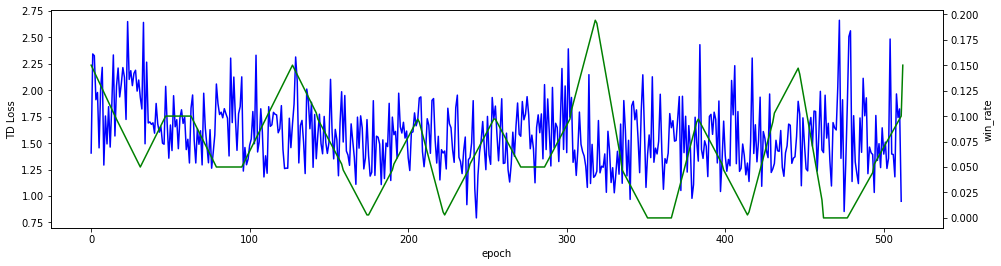

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_xlabel("epoch")
ax.set_ylabel("TD Loss")
ax.plot(loss_data, "b-")

#ax1 = ax.twinx()
#ax1.plot(acc_data, "r-")
#ax1.set_ylabel("accuracy")

ax2 = ax.twinx()
ax2.plot(lnip_winrate_data, "g-")
ax2.set_ylabel("win_rate")
#ax2.spines["right"].set_position(("axes", 1.1))

plt.show()

#view heatmap

In [ ]:
white, black = 1, 2
color = ("white", "black")
def policy_heatmap(state, pred, posts, player): 
  fig, ax= plt.subplots(1, 1, figsize=(6, 6))
  pred = pred.reshape(8, 8)
  #sns.heatmap(pred, square = True, ax = ax)
  plt.imshow(pred, interpolation='nearest', cmap='magma')
  plt.colorbar()

  for y in range(8):
    for x in range(8):
      st = state[y][x]

      if x + 8*y in posts:
          r = pat.Rectangle(xy=(x-0.38, y-0.38), width=0.8, height=0.8, linewidth=2, ec='g', fill=False)
          ax.add_artist(r)

      if st > 0:
        if st == 1:
          fc, ec = 'w', 'k' #face=white, edge=black
        elif st == 2:
          fc, ec = 'k', 'w'
        c = pat.Circle(xy=(x, y), radius=0.4, fc=fc, ec=ec, fill = True)
        ax.add_artist(c)

  pred_num = np.argsort(-pred.reshape(64))
  for y in range(8):
    for x in range(8):
      px = pred_num[x + y*8] % 8
      py = pred_num[x + y*8] // 8
      ax.text(px-0.25, py+0.25, f"{x + y*8 + 1}", size=10, color='green', fontweight='bold')
  if player == white:
    title = "player: white"
  else:
    title = "player: black"
  ax.set_title(title)
  plt.show()

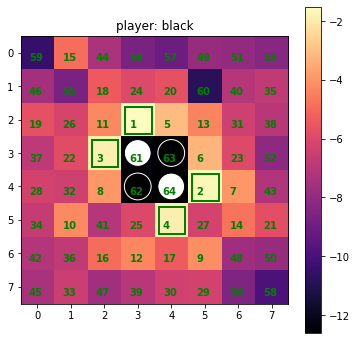

19 19
[18, 20, 34]


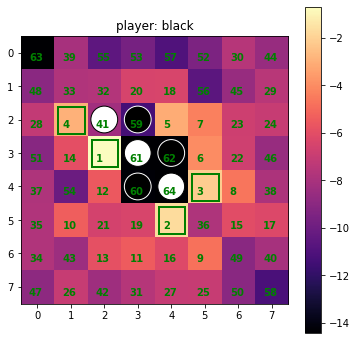

37 37
[11, 20, 29, 43, 45]


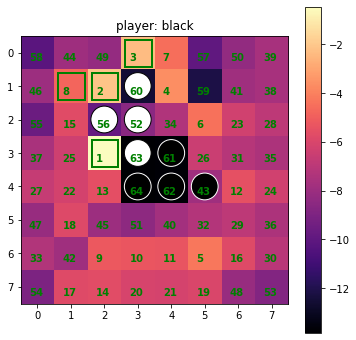

10 10
[2, 9, 20, 29, 43, 45]


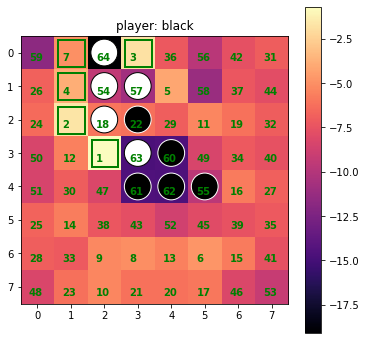

3 3
[4, 12, 20, 29, 43, 45, 46]


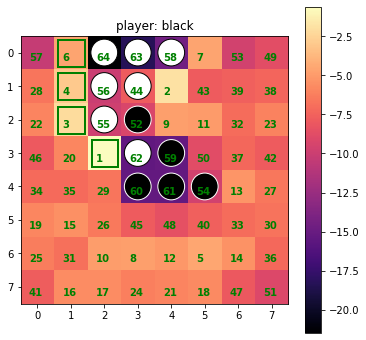

26 26
[20, 34, 43, 45, 46]


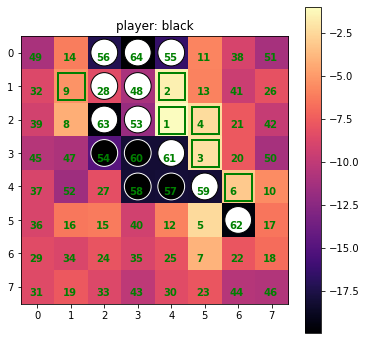

12 12
[13, 20, 21, 25, 34, 42, 43, 44, 45]


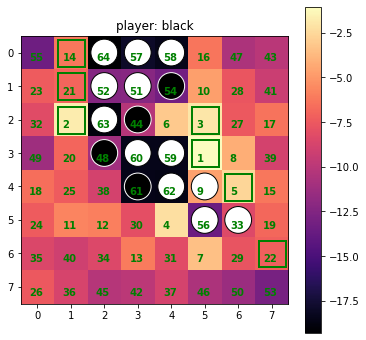

29 29
[13, 20, 21, 22, 34, 43]


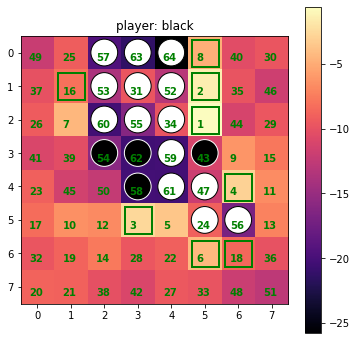

43 43
[21, 25, 30, 33, 34, 38, 42, 44, 51]


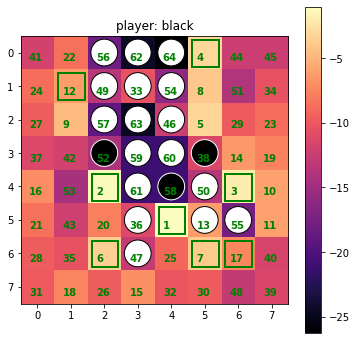

44 44
[21, 22, 25, 30, 33, 34, 38, 42, 52]


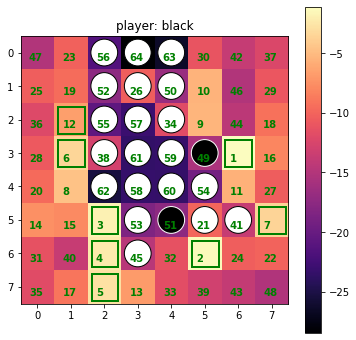

53 53
[22, 30, 38, 52, 54, 60, 62]


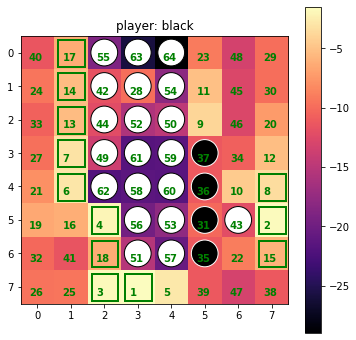

59 59
[22, 30, 38, 54, 60, 61, 62]


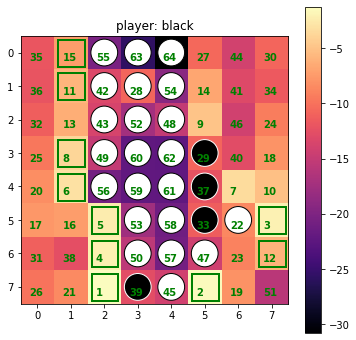

58 58
[21, 22, 30, 38, 42, 50, 54, 57]


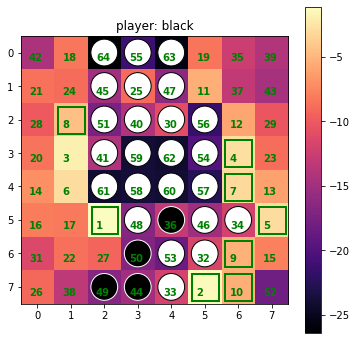

33 47
wrong action: 33 correct: 47


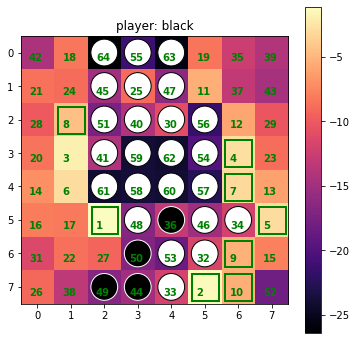

[38, 39, 42, 50, 54, 55, 57]


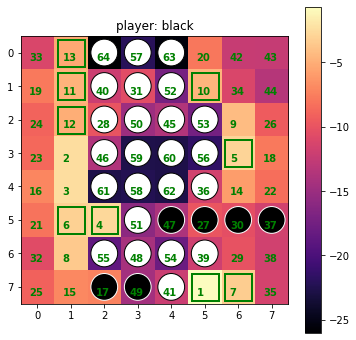

62 62
[38, 39, 54, 55, 57, 61]


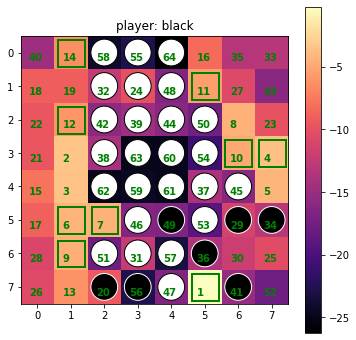

61 61
[54, 55]


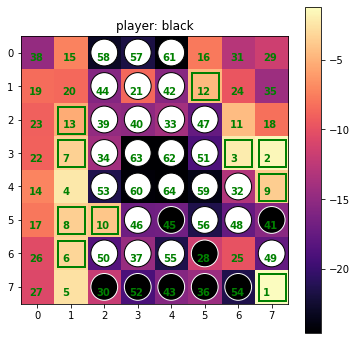

25 25
[24, 32, 33, 39, 41, 42, 54]


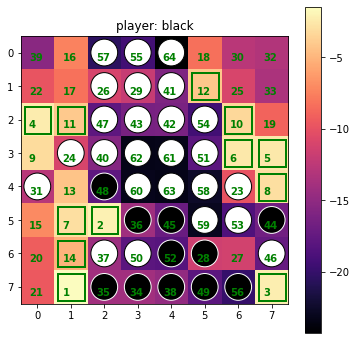

42 42
[33, 39, 41, 49, 57]


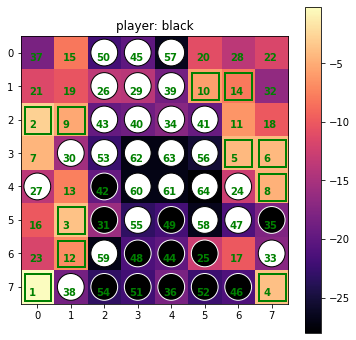

56 56
[33, 39, 41, 49, 54]


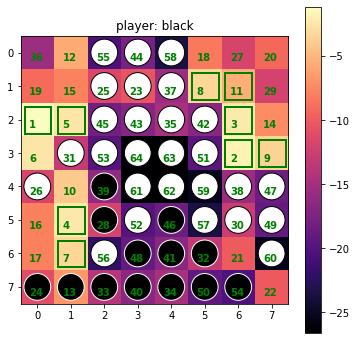

41 41
[33, 40, 48, 49]


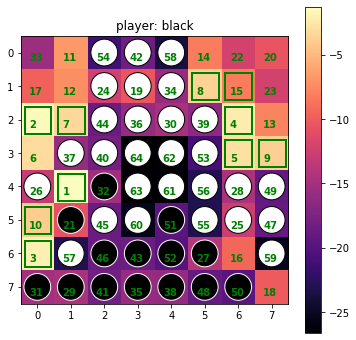

22 22
[23, 30, 33, 40, 48, 54]


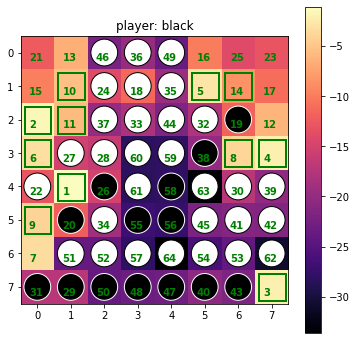

16 16
[15, 23, 24, 30, 33, 40, 48]


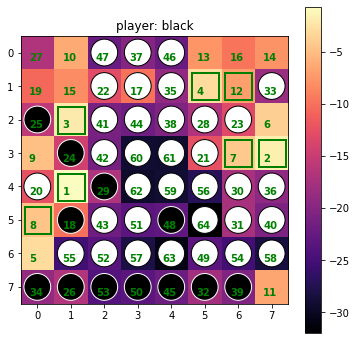

33 33
[17, 24, 40, 48]


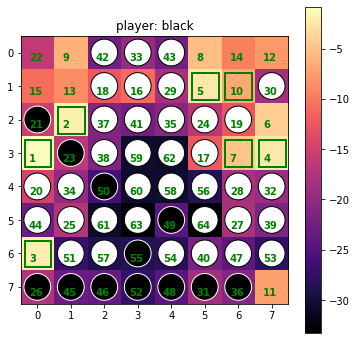

24 24
[8, 17]


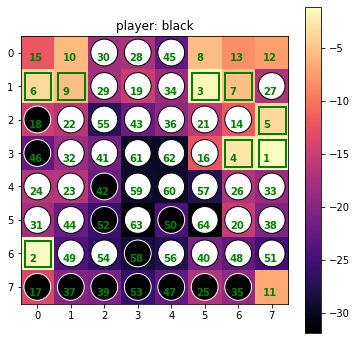

31 31
[8, 23, 30]


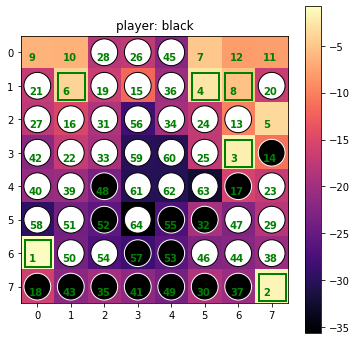

48 48
[23, 30]


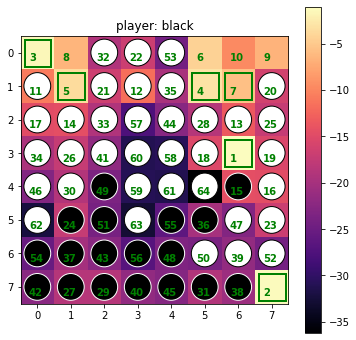

63 63
[30]


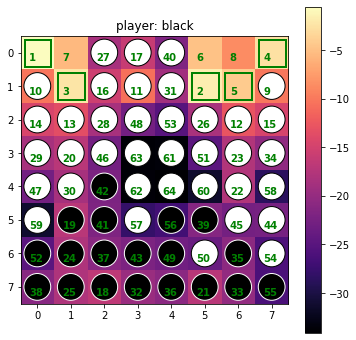

0 0
player: white was skipped


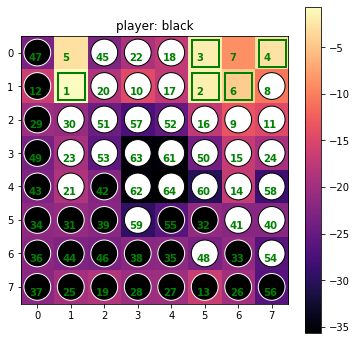

9 9
player: white was skipped


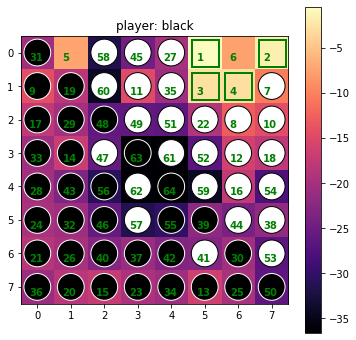

5 5
[6, 13]


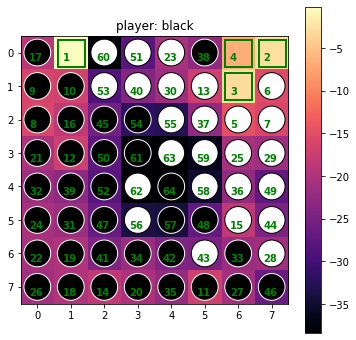

1 1
player: white was skipped


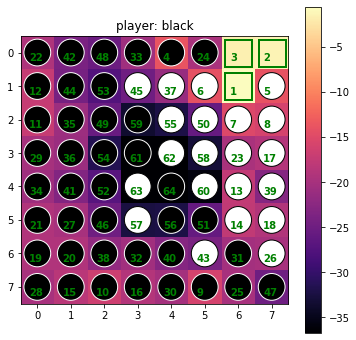

14 14
[6]


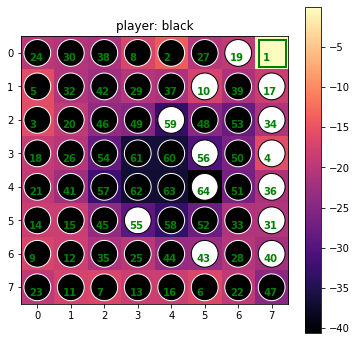

7 7
wrong action: 25 correct: 44


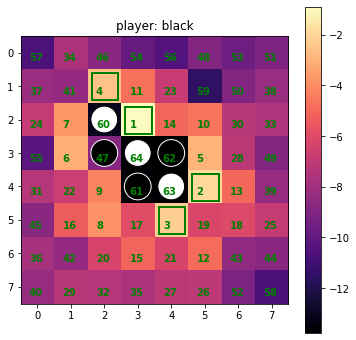

wrong action: 49 correct: 37


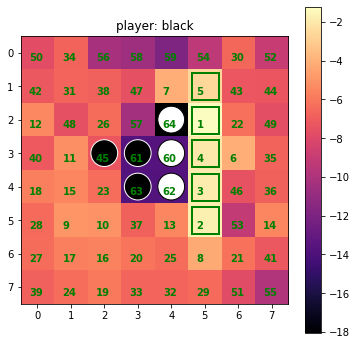

wrong action: 51 correct: 37


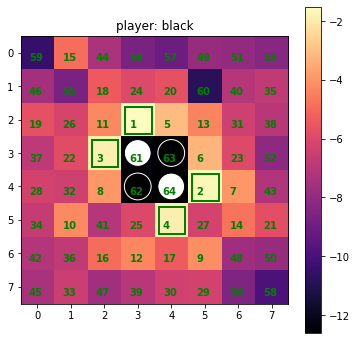

wrong action: 32 correct: 26


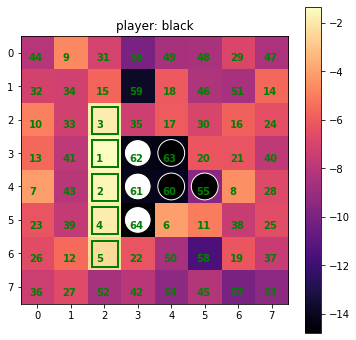

wrong action: 10 correct: 44


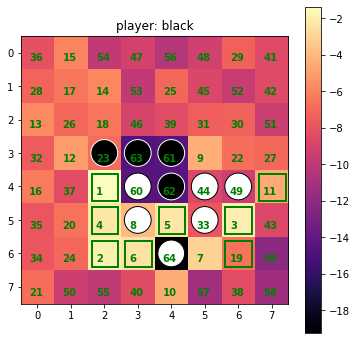

wrong action: 48 correct: 2


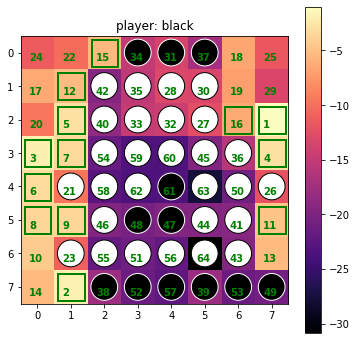

wrong action: 29 correct: 53


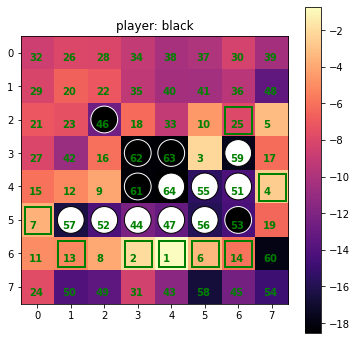

wrong action: 49 correct: 40


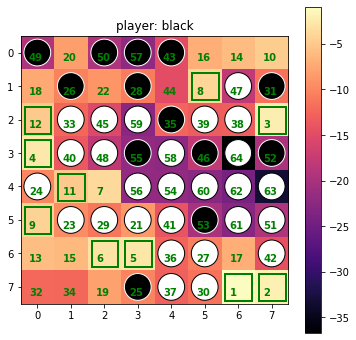

wrong action: 1 correct: 51


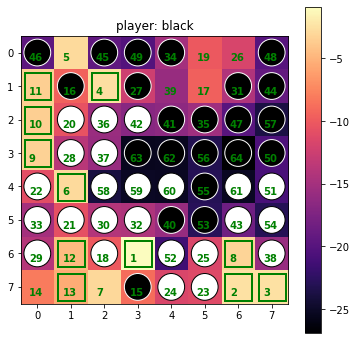

wrong action: 37 correct: 41


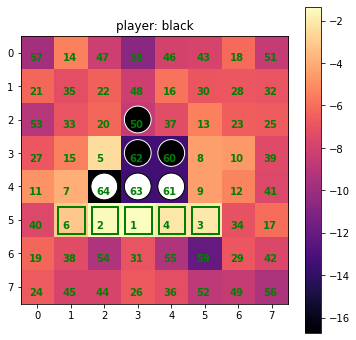

wrong action: 2 correct: 37


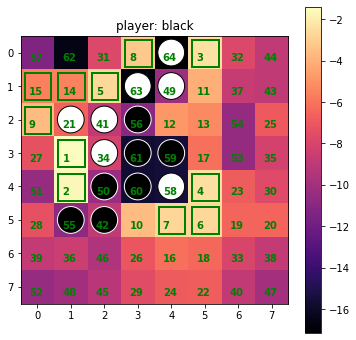

wrong action: 47 correct: 43


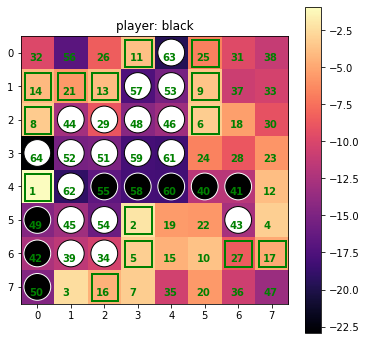

wrong action: 47 correct: 13


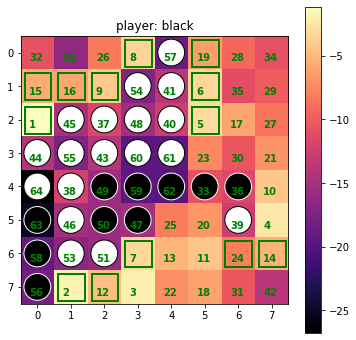

wrong action: 21 correct: 26


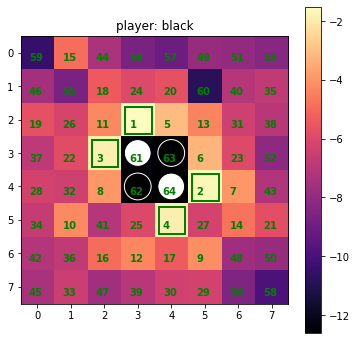

wrong action: 62 correct: 24


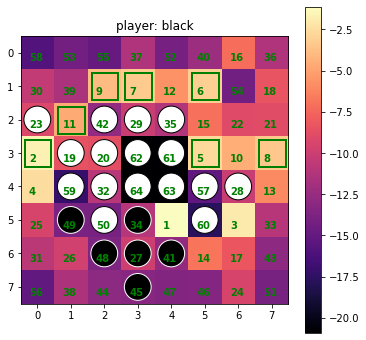

wrong action: 10 correct: 30


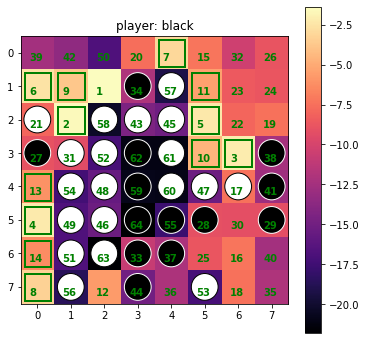

wrong action: 53 correct: 5


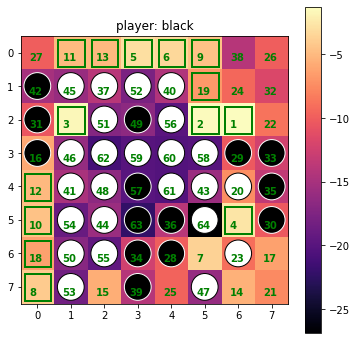

wrong action: 53 correct: 10


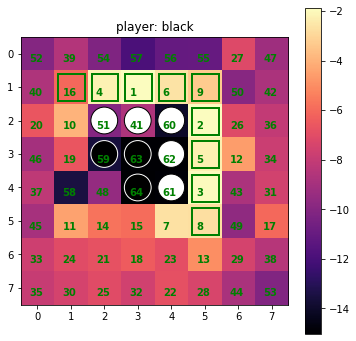

wrong action: 39 correct: 34


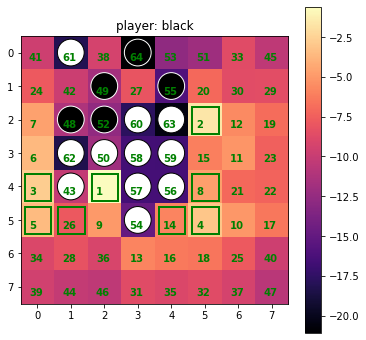

wrong action: 53 correct: 47


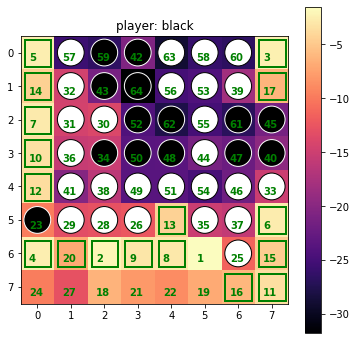

wrong action: 23 correct: 53


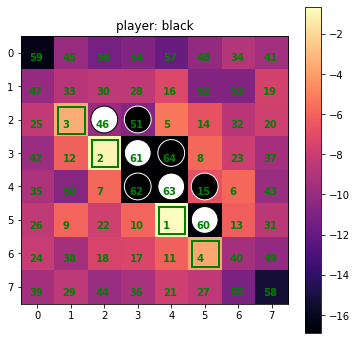

wrong action: 5 correct: 55


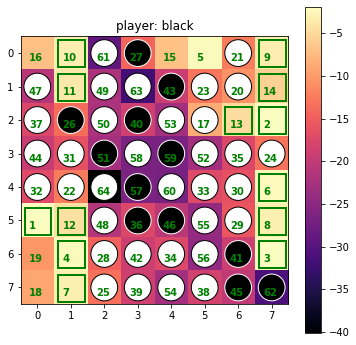

AI: black
win: white 1 : black 9
acc: 0.9258
Right: 287 Wrong: 23


In [ ]:
np.set_printoptions(precision=4, floatmode='maxprec_equal') #for print pred
model = policy_model
AI = black
acc = [0, 0] #True, False
win = [0, 0] # white, black
for play in range(10):
  model.eval()
  env.reset()
  while not env.done:
    #env.render()
    player = env.player
    posts, _, _ = env.next_place
    if len(posts) > 0:#black = policy model
      org_state = env.render("rgb_array").copy()
      state = org_state.astype("float32")
      white_st = np.where(state == 3 - player, 1, 0)
      black_st = np.where(state == player, 1, 0)
      bw_st = np.where(state > 0, 1, 0)
      state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
      state = torch.tensor(state).float()
      state = state.to(device)
      with torch.no_grad():
        pred = model(state)
        #pred_action = pred.max(1)[1].item() #determine
        #tposts = torch.tensor([posts]).long().to(device)
        #toplace = pred.gather(1, tposts)
        pred_action = nn.Softmax(dim=0)(pred.reshape(64)) #prob
        pred_action = torch.multinomial(pred_action, 1) #prob
        
        pred = nn.LogSoftmax(dim = 1)(pred) #Log or raw
        pred = pred.clone().detach().to('cpu').numpy()
      
      if player == AI:
        if play == 0:
          pred = pred.reshape(8, 8)
          #for i in range(8):
              #print(pred[i]/10) #1/10 to match all precisions
          policy_heatmap(org_state, pred, posts, player)
        #placeid = toplace.max(1)[1]
        #action = tposts[0][placeid]
        action = pred_action
      else:
        if play == 0:
          print(posts)
        action = torch.tensor(-1, device = device, dtype = torch.long)

    else:
      if play == 0:
        print(f"player: {color[player-1]} was skipped")

    _, r_action, _, reward, _, player = env.step(action.item())
    if player != AI:
      if play == 0:
        print(pred_action.item(), r_action)
      if r_action < 0:
        pass #skipped
      elif pred_action == r_action:
        acc[0] += 1
      else:
        acc[1] += 1
        print(f"wrong action: {pred_action.item()} correct: {r_action}")
        policy_heatmap(org_state, pred, posts, 3-player)

  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  win[winner-1] += 1

#env.render()

print(f"AI: {color[AI-1]}")
print(f"win: white {win[0]} : black {win[1]}")
print(f"acc: {acc[0]/sum(acc):.4f}")
print(f"Right: {acc[0]} Wrong: {acc[1]}")